# 3.2 - Wavelet-Transformation

<img style="float: right; margin:5px 0px 0px 10px" src="img/2-Titel.png" width="400">
Die Wavelet-Transformation kann als Verbesserung der Kurzzeit-Fourier-Transformation (STFT) angesehen werden. Als Wavelet-Transformation wird eine Familie von linearen Zeit-Frequenz-Transformationen in der Mathematik und den Ingenieurwissenschaften bezeichnet. Mit dem Begriff Wavelet wird in der Mathematik eine Gruppe von Funktionen mit wellenartigem Charakter bezeichnet. Wavelets beschreiben die Funktionsbasis einer kontinuierlichen oder diskreten Wavelet-Transformation. Im Gegensatz zu den Sinus- und Kosinus-Funktionen der Fourier-Transformation besitzen die meistverwendeten Wavelets nicht nur Lokalität im Frequenzspektrum, sondern auch im Zeitbereich. Dabei ist „Lokalität“ im Sinne kleiner Streuung zu verstehen.  

## Inhalt  
<table style="width:256px; border: 1px solid black; display: inline-block">
    <tr>
        <td  style="text-align:right" width=64px><img src="img/2-1.jpg" style="float:left"></td>
        <td style="text-align:left" width=256px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#1'>
                1. Unzulänglichkeiten der STFT
            </a>
        </td>
    </tr>  
    <tr>
        <td style="text-align:right"><img src="img/2-2.png" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#2'>
                2. Wavelets
            </a>
        </td>
    </tr>
    <tr>
        <td style="text-align:right"><img src="img/2-3.png" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#3'>
                3. Implementierung
            </a>
        </td>
    </tr>
    <tr>
        <td style="text-align:right"><img src="img/2-4.jpg" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#4'>
                4. Anwendungsbeispiele
            </a>
        </td>
    </tr>
</table>

----

<a id='1'></a>
<div>
    <img src="img/2-1.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        1. Unzulänglichkeiten der STFT 
    </h2>
</div>

Schauen wir nochmal das Beispiel der STFT in 3.1 und versuchen verschiedene Auflösungen (Zeitfensterlängen):

In [1]:
# Externe Module importieren
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy import fftpack, signal, misc
from scipy.io import wavfile
import simpleaudio as sa

In [2]:
# Initialisierung der Variablen
fs_Hz = 200                            # Abtrastfrequenz
T_s = 12                               # Zeitdauer
L = fs_Hz*T_s                          # Länge des Signals
N = int(2**(np.floor(np.log2(L))+1))   # Länge von FFT
t_s = np.linspace(0, T_s, L)           # Zeitbereich
t4_s = np.linspace(0, T_s/4, L//4)     # Viertelzeitbereich
f_Hz = np.linspace(0, fs_Hz/2, N//2)   # Frequenzbereich

# Signale mit unterschiedlichen Zeitreihen
seg1 = 2 * np.sin(10*np.pi*(t4_s))
seg2 = 10 * np.sin(20*np.pi*t4_s)
seg3 = 5 * np.sin(35*np.pi*t4_s)
seg4 = 7 * np.sin(5*np.pi*t4_s)
s1 = np.array([seg1, seg2, seg3, seg4]).flatten()
s2 = np.array([seg3, seg4, seg2, seg1]).flatten()
s3 = np.array([seg2, seg1, seg4, seg3]).flatten()

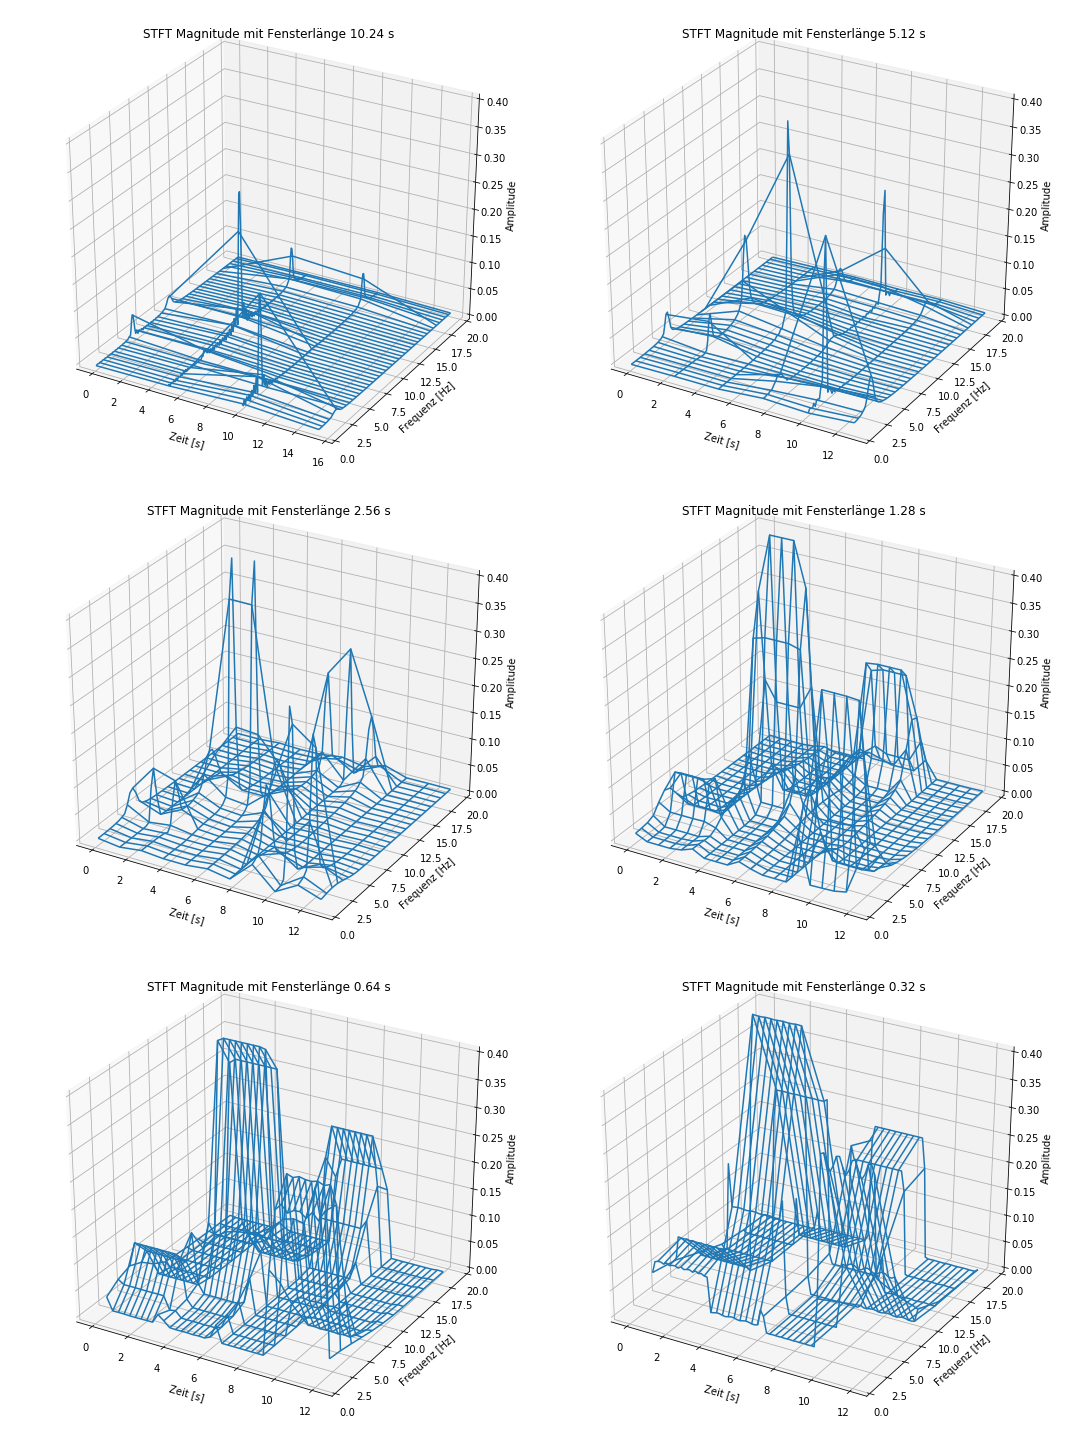

In [3]:
# Spektral durch STFT mit verschiedenen Fensterlängen
s = s1/np.max(s1)
fig = plt.figure()
fig.set_size_inches(15, 20)

for i in range(1, 7):
    
    windowLength = N // (2**(i))
    TWindow_s = windowLength/fs_Hz
    fSTFT_Hz, tSTFT_s, Zxx = signal.stft(s, fs_Hz, nperseg=windowLength)     
    fLimit_Hz = (fSTFT_Hz>0) & (fSTFT_Hz<20)             
    fSTFT_Hz = fSTFT_Hz[fLimit_Hz]                        
    Zxx = Zxx[fLimit_Hz]
    
    ax = fig.add_subplot(3,2,i, projection='3d')
    ax.set_title('STFT Magnitude mit Fensterlänge %.2f s' %TWindow_s)
    ax.set_xlabel('Zeit [s]') 
    ax.set_ylabel('Frequenz [Hz]')  
    ax.set_zlabel('Amplitude')  
    ax.set_ylim(0, 20)
    ax.set_zlim(0, 0.4)
#   ax.plot_surface(tSTFT_s[None, :], fSTFT_Hz[:, None], abs(Zxx), cmap=cm.cool) 
    ax.plot_wireframe(tSTFT_s[None, :], fSTFT_Hz[:, None], abs(Zxx))     

fig.tight_layout()          
plt.show()

Wir haben anhand des Beispiels gesehen, dass es im Vergleich zu einer spektrografischen Darstellung mit mittlerer Zeitfensterlänge (1.28 s) durch Verlängerung bzw. Verkürzung des Zeitfensters möglich ist, mehr spektrale Details (Schmalbandspektrogramm) bzw. mehr zeitliche Details (Breitbandspektrogramm) zu gewinnen. Am besten wäre es, man könnte beide Vorteile in einem Spektrogramm vereinen, und zwar möglichst unter Berücksichtigung der folgenden Gesichtspunkte:
- Bei niedrigen Frequenzen wünscht man sich eine gute Frequenzauflösung.  
- Die höheren Frequenzen enthalten offensichtlich weniger relevante spektrale Information, sodass ihre spektrale Auflösung durch die STFT zu genau erscheint. Man würde sich deshalb wünschen, dass in diesem Bereich des Spektrogramms die spektrale Auflösung verringert werden könnte, damit man zugleich von einer deutlich verbesserten zeitlichen Auflösung profitiert.  

Überträgt man diese Wünsche auf das Raster eines Spektrogramms, sollte es so modifiziert werden, dass die dargestellten Rechtecke bei tiefen Frequenzen möglichst flach (und damit breit), bei hohen Frequenzen möglichst schmal (und damit hoch) sein sollten (größere Zeitfenster für Niederfrequenzen und kleinere Fenster für Hochfrequenzen). Das ist kein Widerspruch zur Unschärferelation, die nur einen einheitlichen Flächeninhalt der Rechtecke fordert. Trotzdem sind die Wünsche durch die STFT nicht erfüllbar, weil sie nur eine einheitliche Rasterung der Zeit-Frequenz-Ebene zulasst. Unabhängig von deren Frequenz besitzt die zum  Ausschneiden benutzte Fensterfunktion $ h(t) $ stets eine feste Länge, was dazu führt, dass das Spektrum der Aufbaufunktionen auch stets eine konstante absolute Bandbreite hat. Daher müssen wir nach Alternativen zur STFT suchen, um die Wünsche zu erfüllen. Es gibt mehrere Möglichkeiten, die Analyse von Signalen über der Zeit-Frequenz-Ebene flexibler zu gestalten, beispielsweise Modifikationen am Fourier-Integral, Wavelet-Transformation und Filterbank-Analyse. Hier konzentrieren wir uns auf Wavelet-Transformation.

----

<a id='2'></a>
<div>
    <img src="img/2-2.png" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        2. Wavelets
    </h2>
</div>

STFT dient dazu, das Signal zu fenstern und FFT in Segmenten durchzuführen. Anders als STFT, die Wavelet-Transformation ändert direkt die Funktionsbasis der Transformation: Die unendliche trigonometrische Funktionsbasis wird durch die endliche abgeschwächte Wavelet-Basis ersetzt, die nicht nur Frequenz erhalten werden, sondern auch die Zeit lokalisieren kann. Bei der Fourier-Analyse wird das Signal in Sinuswellen mit bestimmten Frequenzen zerlegt, während bei der Wavelet-Analyse das Signal in eine Pan- und Zoom-Version von Wavelets zerlegt wird. Daher befassen wir uns mit der sogenannten Wavelet-Transformation, in deren Transformationsintegral Aufbaufunktionen verwendet werden sollen, die möglichst freizügig wählbar sind. Solche Aufbaufunktionen lauten damit:
\begin{equation}
\psi _{a,t}(\tau )=\frac{1}{\sqrt{a}}\psi (\frac{\tau -t}{a}) 
\end{equation} 
Nachdem die Aufbaufunktionen definiert sind, ist die Angabe der Hintransformationsgleichung der Wavelet-Transformation als Skalarprodukt sofort möglich: 
\begin{equation}
S(a,t)=\left \langle s,\psi _{a,t}\right \rangle=\frac{1}{\sqrt{a}}\int_{-\infty }^{\infty }s(\tau )\psi^{*} (\frac{\tau -t}{a})d\tau 
\end{equation} 
Aus der Formel ist ersichtlich, dass ähnlich wie die STFT die Wavelet-Transformation auch eine Bildfunktion liefert, die von zwei Variablen abhängig ist: Skala $a$ und Translation $t$. Die Skala $a$ steuert die Expansion und Kontraktion der Wavelet-Funktion, und der Translationsbetrag $t$ steuert die Translation der Wavelet-Funktion. Die Skala entspricht der Frequenz (umgekehrt proportional) und der Betrag der Translation entspricht der Zeit. Laut Definition bewirkt Vergrößerung von $a$ eine Verbreiterung des Wavelets. Wenn also das Mutter-Wavelet eine bestimmte Spektralkomponente mit der Frequenz $\omega_{m}$ besitzt, verringert sich diese bei $a$-facher Dehnung des Wavelets auf $\omega_{m}/a$, und das Wavelet passt nun besser zu niederfrequenteren Signalbestandteilen. Für die grafische Darstellung der Zeit-Frequenz-Ebene bedeutet das, dass man im allgemeinen Fall in "Frequenzrichtung" Zahlenwerte nur für die Skale auftragen kann, und zwar in gegenläufiger Richtung.

Zur Implementierung verwenden wir das externe Modul __[PyWavelets](https://pywavelets.readthedocs.io/en/latest/ref/index.html)__. Durch [pywt.families()](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html) können wir die build-in Wavelets-Familien zu sehen: 

In [4]:
# Build-in Wavelets-Familien listen
import pywt

print('Wavelet-Familie (Kurzname):')
for i in range(len(pywt.families())):
    print('%s (%s)' %(pywt.families(short=False)[i], pywt.families()[i]))

Wavelet-Familie (Kurzname):
Haar (haar)
Daubechies (db)
Symlets (sym)
Coiflets (coif)
Biorthogonal (bior)
Reverse biorthogonal (rbio)
Discrete Meyer (FIR Approximation) (dmey)
Gaussian (gaus)
Mexican hat wavelet (mexh)
Morlet wavelet (morl)
Complex Gaussian wavelets (cgau)
Shannon wavelets (shan)
Frequency B-Spline wavelets (fbsp)
Complex Morlet wavelets (cmor)


Daraus kann man finden, dass der große Unterschied zwischen Fourier-Transformation und Wavelet-Transformation ist: Die Fourier-Transformation hat nur eine Art von Transformation, aber die Wavelet-Transformation kann viele Arten von Transformation haben. Basierend auf der Art der Skalierung und Translation werden die Wavelet-Transformation im Allgemeinen in zwei Klassen unterteilt: CWT (kontinuierliche) und DWT (diskrete).
- __CWT__ ist eine Wavelet-Transformation, bei der Skalierung und Übersetzung beliebig eingestellt werden können. CWT wird oft verwendet, um ein Skalogramm zu erstellen.
- __DWT__ ist eine Art Wavelets, die den Wert von Skalierung (Potenz von 2) und Translation (ganze Zahl) einschränken. DWT wird normalerweise verwendet, um das reale Signal zu entstören. Wir können DWT beispielsweise zur Komprimierung von Computer Daten wie Bildern verwenden.

Durch pywt.wavelist() können Wavelet-Funktionen zur Auswahl gelistet werden:

In [5]:
# Build-in Wavelets anzeigen
wavelets_continuous = pywt.wavelist(kind='continuous')
wavelets_discrete = pywt.wavelist(kind='discrete')
print('\n CWT:', wavelets_continuous, end='')
print('\n\n DWT:', wavelets_discrete, end='')


 CWT: ['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']

 DWT: ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8'

Anschließend erstellen wir einige Wavelets zum Vergleich:

In [6]:
# Wavelets erstellen und Eigenschaften anzeigen
wavenames = ['gaus1', 'cgau1', 'morl', 'cmor2-1', 'bior1.1', 'coif1', 'db1', 'dmey', 'haar', 'rbio1.1', 'sym2']
for wavename in wavenames:
    if wavename in wavelets_discrete:
        wav = pywt.Wavelet(wavename)               # Diskretes Wavelet erstellen
    else:
        wav = pywt.ContinuousWavelet(wavename)     # Kontinuierliches Wavelet erstellen  
    print('\n', wav)


 ContinuousWavelet gaus1
  Family name:    Gaussian
  Short name:     gaus
  Symmetry:       anti-symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False

 ContinuousWavelet cgau1
  Family name:    Complex Gaussian wavelets
  Short name:     cgau
  Symmetry:       anti-symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    True

 ContinuousWavelet morl
  Family name:    Morlet wavelet
  Short name:     morl
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False

 ContinuousWavelet cmor2-1
  Family name:    Complex Morlet wavelets
  Short name:     cmor
  Symmetry:       asymmetric
  DWT:            False
  CWT:            True
  Complex CWT:    True

 Wavelet bior1.1
  Family name:    Biorthogonal
  Short name:     bior
  Filters length: 2
  Orthogonal:     False
  Biorthogonal:   True
  Symmetry:       symmetric
  DWT:            True
  CWT:            False

 Wavelet coif1
  Family name:    Coif

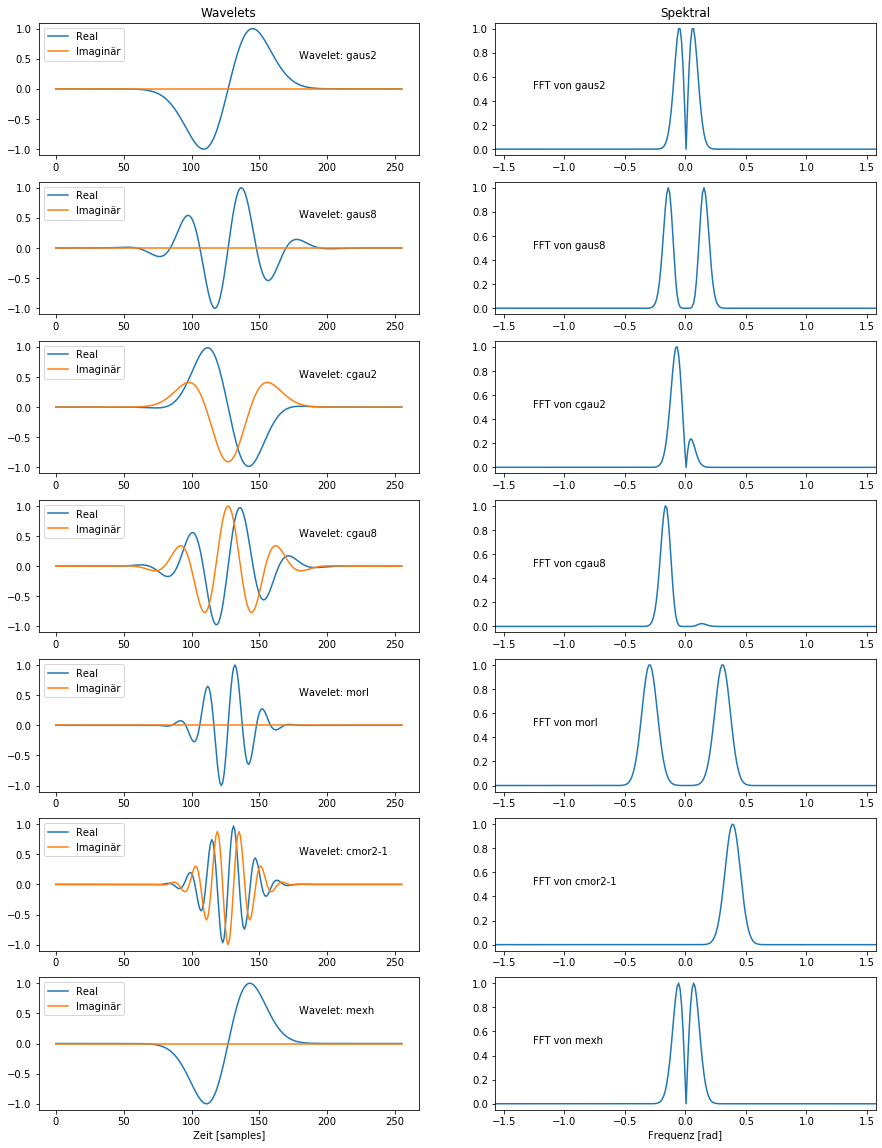

In [7]:
# kontinuierliche Wavelets darstellen
wavenames = ['gaus2','gaus8', 'cgau2', 'cgau8', 'morl', 'cmor2-1', 'mexh']
fig, axes = plt.subplots(len(wavenames), 2, figsize=(15, 20))

for n, wavename in enumerate(wavenames):

    wav = pywt.ContinuousWavelet(wavename) 
    int_psi, x = pywt.integrate_wavelet(wav)   # Integrate Wavelet-Funktion, x-Gitter
    int_psi /= np.abs(int_psi).max()
    wavLength = len(int_psi)

    # Graphische Darstellung
    t = np.arange(wavLength)
    axes[n, 0].plot(t, int_psi.real, int_psi.imag)
    axes[n, 0].legend(['Real', 'Imaginär'], loc='upper left')
    axes[n, 0].set_ylim([-1.1, 1.1])
    axes[n, 0].text(wavLength*0.7, 0.5, 'Wavelet: {}'.format(wavename))
    
    f = np.linspace(-np.pi, np.pi, wavLength*2)
    psi_fft = np.fft.fftshift(np.fft.fft(int_psi, n=wavLength*2))
    psi_fft /= np.abs(psi_fft).max()
    axes[n, 1].plot(f, np.abs(psi_fft))
    axes[n, 1].set_xlim([-np.pi/2, np.pi/2])    
    axes[n, 1].text(-np.pi*0.4, 0.5, 'FFT von {}'.format(wavename))

axes[0, 0].set_title('Wavelets')
axes[0, 1].set_title('Spektral')
axes[n, 0].set_xlabel('Zeit [samples]')
axes[n, 1].set_xlabel('Frequenz [rad]')
plt.show()

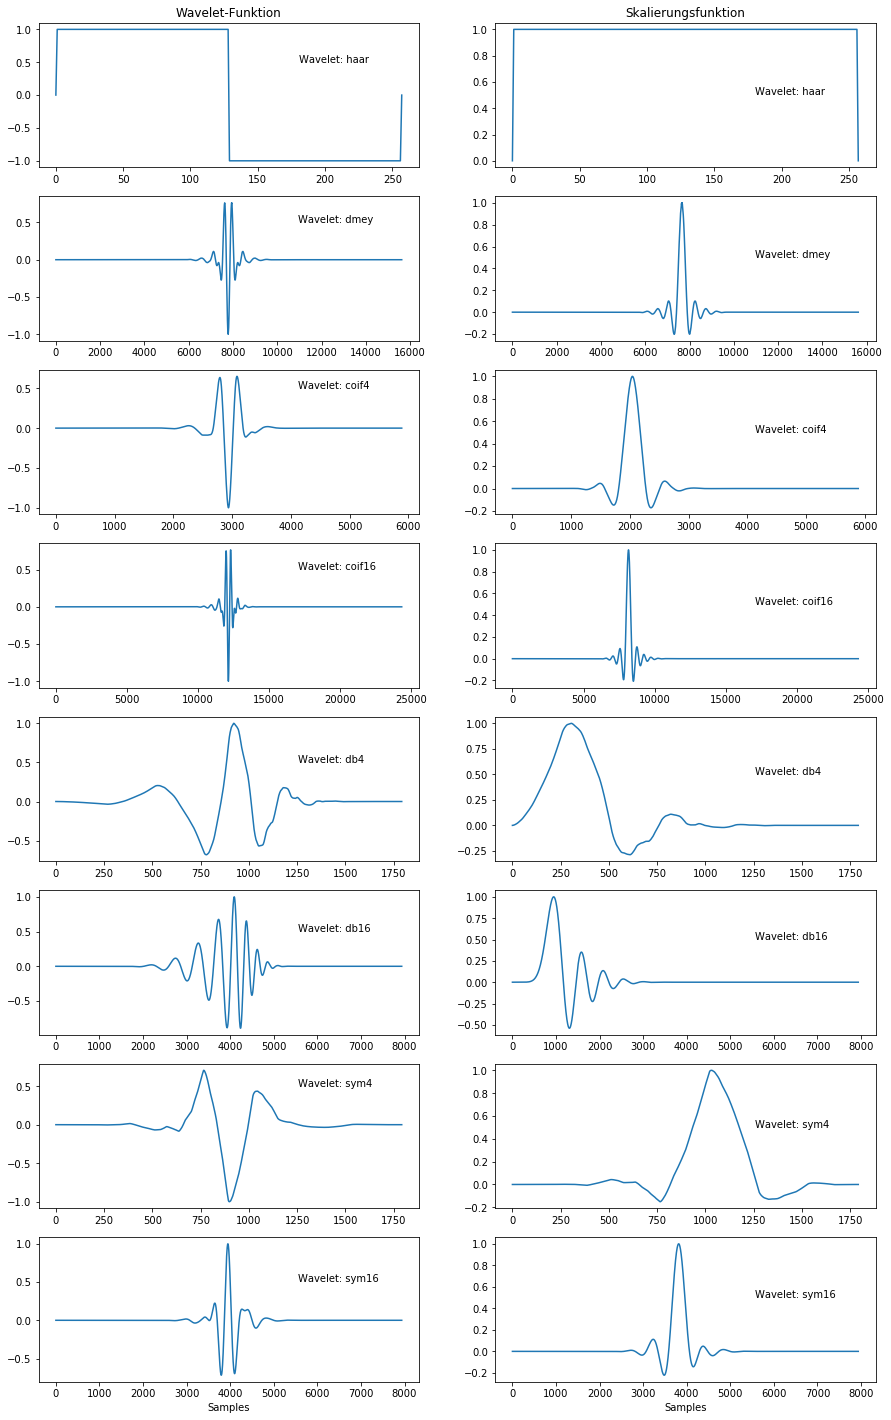

In [8]:
# Diskrete Wavelets darstellen
wavenames = ['haar', 'dmey', 'coif4', 'coif16', 'db4', 'db16', 'sym4', 'sym16']
fig, axes = plt.subplots(len(wavenames), 2, figsize=(15, 25))

for n, wavename in enumerate(wavenames):

    wav = pywt.Wavelet(wavename)
    phi, psi, x = wav.wavefun()    # Skalierungsfunktion, Wavelet-Funktion, x-Gitter
    phi /= np.abs(phi).max()
    psi /= np.abs(psi).max()

    # Graphische Darstellung
    axes[n, 0].plot(psi)
    axes[n, 0].text(len(psi)*0.7, 0.5, 'Wavelet: {}'.format(wavename))    
    axes[n, 1].plot(phi)
    axes[n, 1].text(len(phi)*0.7, 0.5, 'Wavelet: {}'.format(wavename))

axes[0, 0].set_title('Wavelet-Funktion')
axes[0, 1].set_title('Skalierungsfunktion')
axes[n, 0].set_xlabel('Samples')
axes[n, 1].set_xlabel('Samples')
plt.show()

----

<a id='3'></a>
<div>
    <img src="img/2-3.png" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        3. Inplementierung 
    </h2>
</div>

Als nächstes verwenden wir [pywt.cwt()](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html), um kontinuierliche Wavelet-Transformation zu implementieren, Skalogramm darzustellen und mit STFT zu vergleichen:

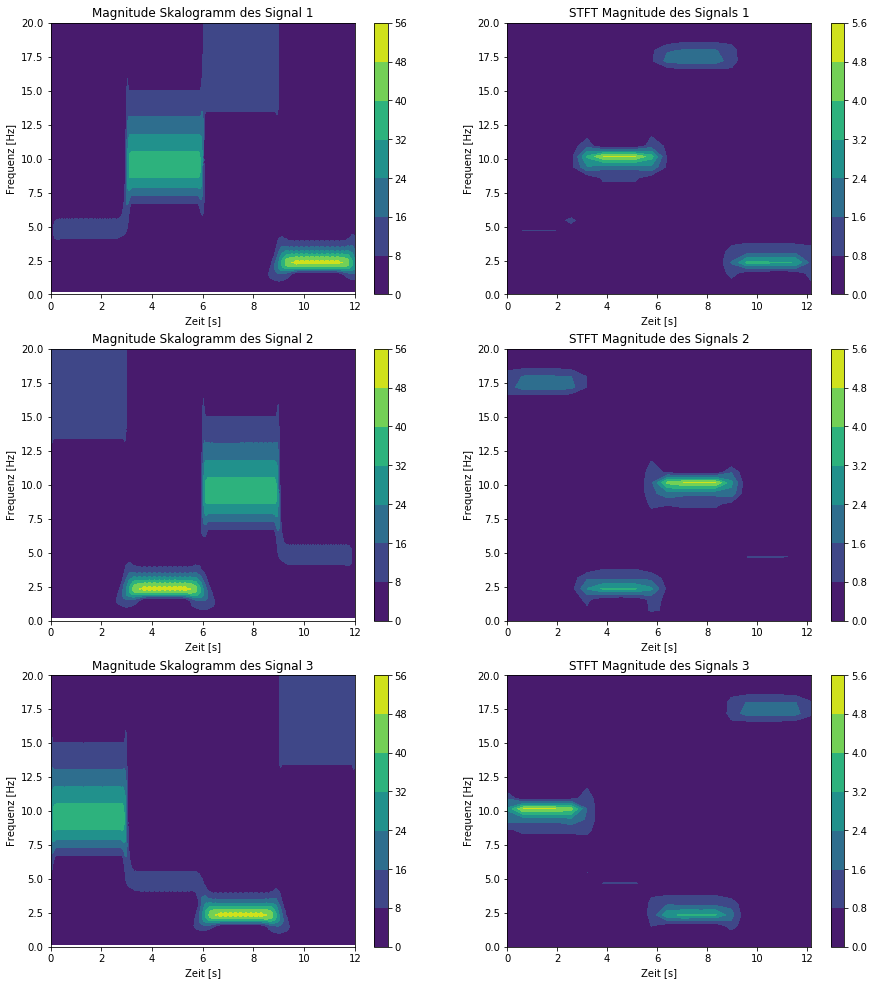

In [9]:
# Vergleich der Wavelet-Transformation mit STFT
wavename = 'cgau8' 
totalScales = 1024
fc_Hz = pywt.central_frequency(wavename)
scales = 2 * fc_Hz * totalScales / np.arange(totalScales, 1, -1)

for i, s in enumerate([s1, s2, s3]): 

    plt.subplot(3, 2, 2*i+1)
    cwt_matrix, fWT_Hz = pywt.cwt(s, scales, wavename, 1/fs_Hz)
    plt.contourf(t_s, fWT_Hz, np.abs(cwt_matrix))
    plt.title('Magnitude Skalogramm des Signal %d' %(i+1))
    plt.ylabel('Frequenz [Hz]')
    plt.xlabel('Zeit [s]')
    plt.ylim(0, 20)
    plt.colorbar()    
    
    plt.subplot(3, 2, 2*i+2)
    fSTFT_Hz, tSTFT_s, Zxx = signal.stft(s, fs_Hz, ('tukey', 0.3))     
    plt.contourf(tSTFT_s, fSTFT_Hz, np.abs(Zxx))
    plt.title('STFT Magnitude des Signals %d' %(i+1))
    plt.xlabel('Zeit [s]') 
    plt.ylabel('Frequenz [Hz]')   
    plt.ylim(0, 20)
    plt.colorbar()
    
plt.gcf().set_size_inches(15, 17)
plt.show()

Außerdem können wir die CWT mit verschiedenen Wavelets vergleichen:

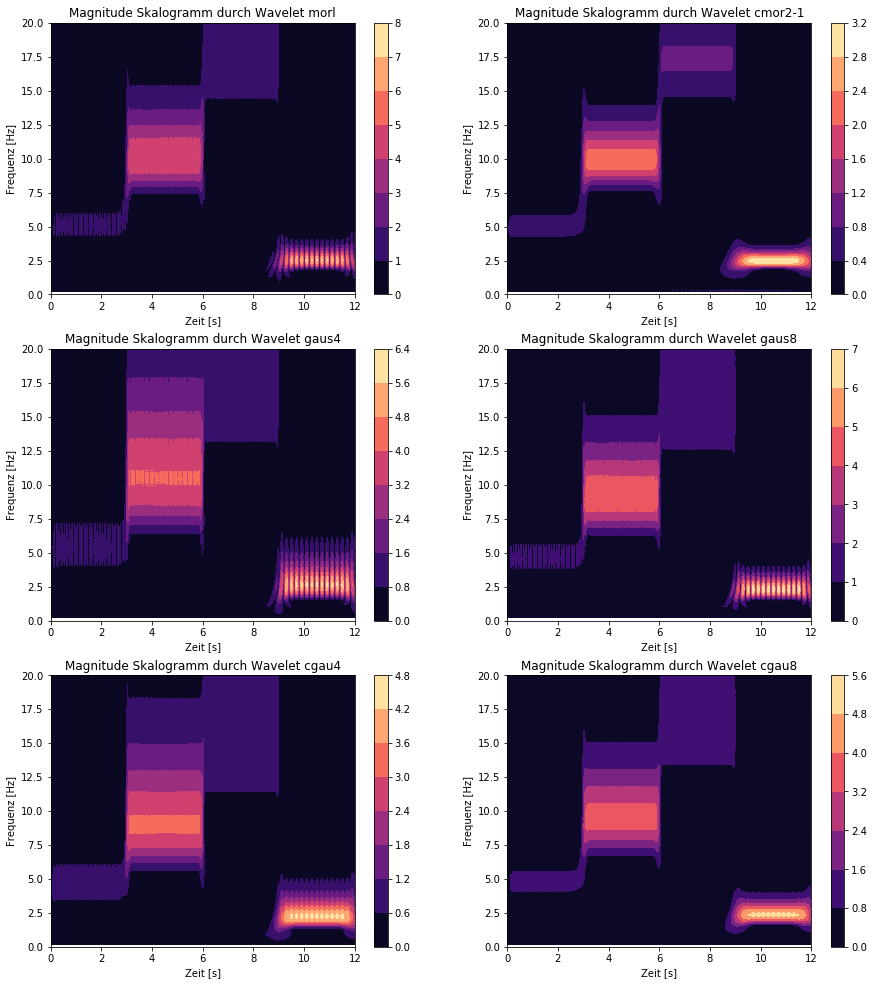

In [10]:
# Wavelet-Transformation mit verschiedenen Wavelets
s = s1/np.max(s1)
fig = plt.figure()
fig.set_size_inches(15, 17)
for i, wavename in enumerate(['morl', 'cmor2-1', 'gaus4','gaus8', 'cgau4', 'cgau8']):  
    fc_Hz = pywt.central_frequency(wavename)
    scales = 2 * fc_Hz * totalScales / np.arange(totalScales, 1, -1)
    cwt_matrix, fWT_Hz = pywt.cwt(s, scales, wavename, 1/fs_Hz) 
    plt.subplot(3,2,i+1)
    plt.contourf(t_s, fWT_Hz, np.abs(cwt_matrix), cmap=cm.magma)
    plt.title('Magnitude Skalogramm durch Wavelet %s' %wavename)
    plt.ylabel('Frequenz [Hz]')
    plt.xlabel('Zeit [s]')
    plt.ylim(0, 20)
    plt.colorbar()
plt.show()

----

<a id='4'></a>
<div>
    <img src="img/2-4.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        4. Anwendungsbeispiele 
    </h2>
</div>

Als ein weiteres Beispiel verwenden wir 2D-DWT für Bildverarbeitung. Zuerst führen wir folgende Codes, um das Package [opencv-python](https://pypi.org/project/opencv-python/) zu installieren (falls noch nicht):

``` python
pip install opencv-python
```

Dann können wir das Modul __cv2__ importieren, um die Bilder zu verarbeiten:

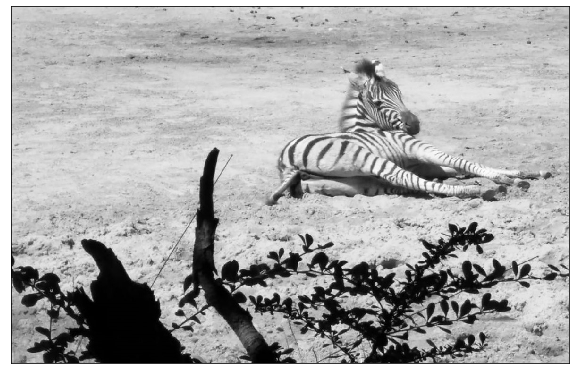

In [16]:
# Bild laden
import cv2
original = cv2.imread('img/2-WT1.jpg') 

# Farbe (BGR in Grau) konvertieren und Bild anzeigen
img = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY).astype(np.float32)   
plt.imshow(img, cmap=cm.gray)   
plt.xticks([])
plt.yticks([])
plt.gcf().set_size_inches(10, 8)
plt.show()

Zur 2D-DWT verwenden wir [pywt.dwt2()](https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html):

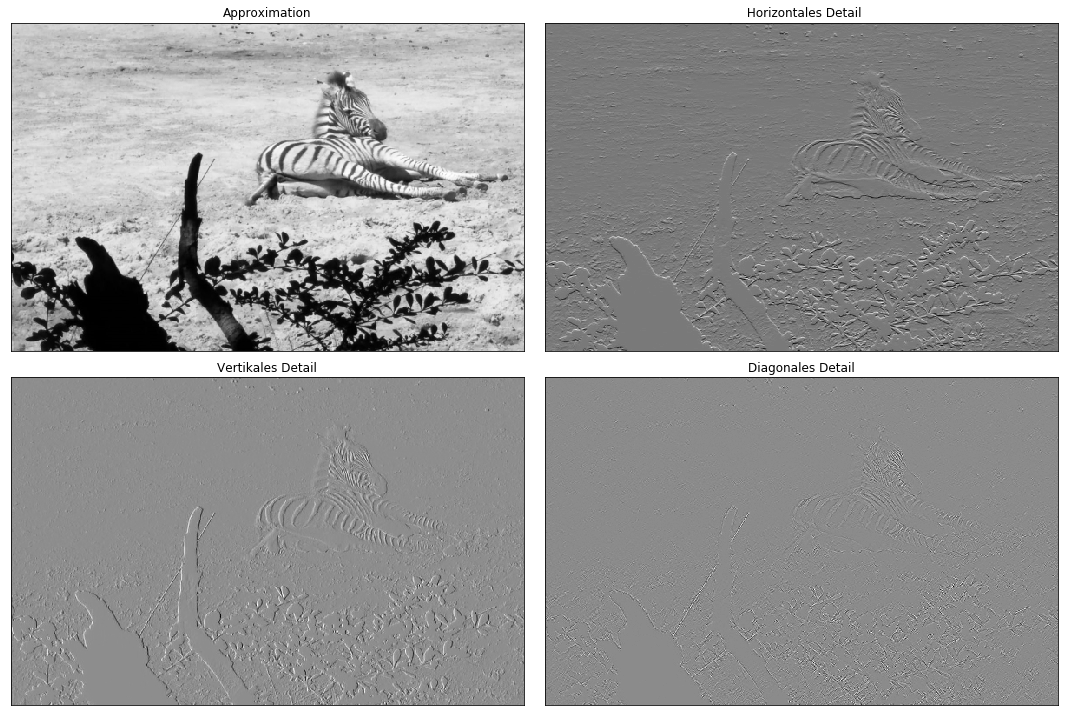

In [17]:
# 2D-Wavelet-Transformation des Bildes 
coeffs = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs

# Darstellung der Approximation und Details
titles = ['Approximation', ' Horizontales Detail', 'Vertikales Detail', 'Diagonales Detail']
fig = plt.figure(figsize=(15, 10))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(a, cmap=cm.gray)
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

An diesem Beispiel können wir sehen: Durch eine gegebene Wavelet-Transformation kann das Bild mit verschiedenen Auflösungen aus dem Originalbild konstruiert werden, wir können nämlich Niederfrequenzinformationen und Hochfrequenzinformationen des Bildes erhalten. Die Niederfrequenzinformationen entsprechen der Mittelwerte, und die Hochfrequenzinformationen entsprechen der Differenzen. D.h., __LL__ ist Niederfrequenzinformation, __LH__ ist horizontale Hochfrequenzinformation, __HL__ ist vertikale Hochfrequenzinformation und __HH__ ist diagonale Hochfrequenzinformation.

Außerdem gehen beim Transformationsprozess keine Informationen verloren, da das Originalbild aus den aufgezeichneten Daten rekonstruiert werden kann:

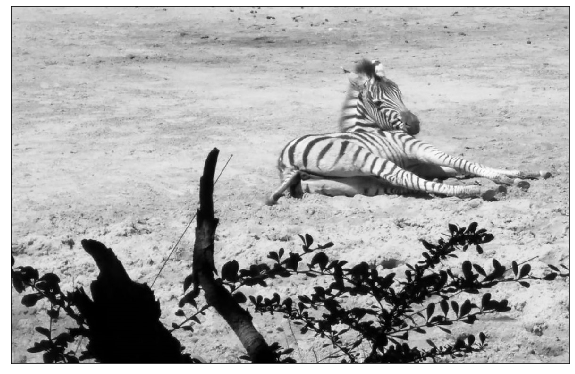

In [18]:
# Originalbild rekonstruieren
img_origin = pywt.idwt2(coeffs, 'haar')

# BGR in RGB konvertieren und anzeigen
plt.imshow(img_origin, cmap=cm.gray)   
plt.xticks([])
plt.yticks([])
plt.gcf().set_size_inches(10, 8)
plt.show()

----

### References

1. Titelbild aus [Clipartmax](https://www.clipartmax.com/middle/m2i8Z5G6m2K9G6m2_ripples-water-ripple-png/)  
2. [Wavelet-Transformation](https://de.wikipedia.org/wiki/Wavelet-Transformation)
3. Lehrbuch: [Intelligente Signalverarbeitung 1 - Signalanalyse](https://katalog.slub-dresden.de/id/0-1654371521/#detail)  
4. [What is Wavelet and How We Use It for Data Science](https://towardsdatascience.com/what-is-wavelet-and-how-we-use-it-for-data-science-d19427699cef)  
5. Wavelet-Transformation-Pakete für Python: [pywavelets](https://pywavelets.readthedocs.io/en/latest/)  
6. OpenCV-Pakete für Python: [opencv-python](https://pypi.org/project/opencv-python/)  
7. Referenz von Colormap: [matplotlib.cm](https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html)